In [1]:
import numpy as np
import pandas as pd
# import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

import seaborn as sns
sns.set()

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import LabelPropagation

In [3]:
# from keras.utils import to_categorical


In [4]:
train_df=pd.read_csv('./project/training_data.csv')
test_df=pd.read_csv('./project/testing_data.csv')


In [5]:
train_df


,title,category
0,The Three Amigos,None
1,Home Essentials Blue Floral Glass Vintage Styl...,Home & Kitchen
2,Cooper Wiring Quiet Toggle Switch Single Pole ...,Tools & Home Improvement
3,Baseboarders&reg; Wall Brackets,Tools & Home Improvement
4,The Great Wave Off Kanagawa Custom Rectangle M...,Office Products
...,...,...
20183,D0309-WML Leviton Decora Screwless Snap-On Wal...,None
20184,South Shore Axess Small 2-Door Storage Cabinet...,None
20185,Patriotic Flip Flop Ornament Assortment of 2,Home & Kitchen
20186,Cybrtrayd Life of the Party A116 Horse Chocola...,None


<BarContainer object of 7 artists>

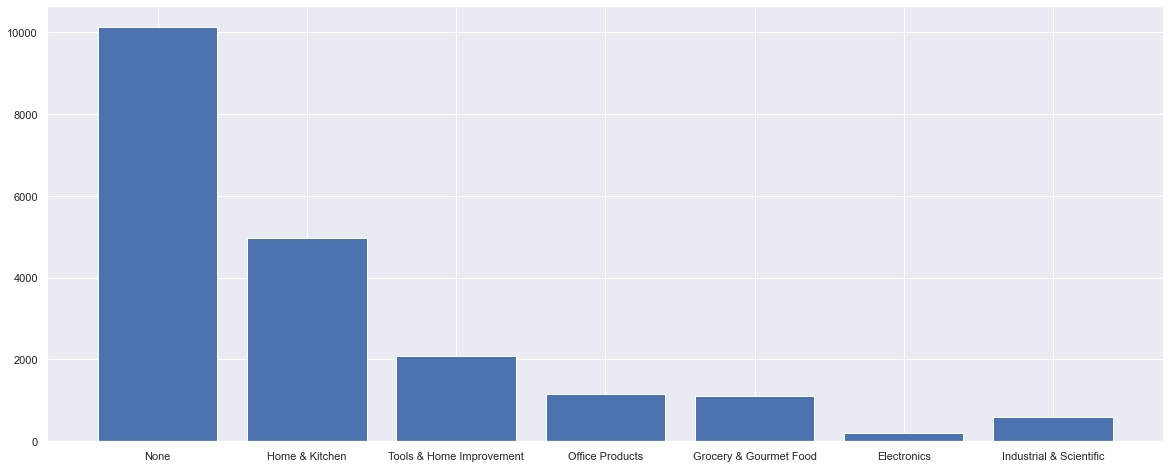

In [6]:
counter = Counter(train_df['category'].tolist())
plt.bar(counter.keys(), counter.values())

## It seems semi supervised Data and Unbalanced with None half our data 
### Let build to check how classical workflow builds and analysis over

In [7]:
docs_per_class = train_df.groupby(['category'], as_index=False).agg({'title':list})
docs_per_class.set_index("category", inplace = True)
docs_per_class
none_title_list=docs_per_class.loc['None']['title']


### Splitting Lable categorical data and None seperately

In [8]:
label_df=train_df[train_df['category']!='None']

label_df['category_label']=label_df['category'].factorize()[0]
label_df


<ipython-input-8-fe4cb2734e70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['category_label']=label_df['category'].factorize()[0]


,title,category,category_label
1,Home Essentials Blue Floral Glass Vintage Styl...,Home & Kitchen,0
2,Cooper Wiring Quiet Toggle Switch Single Pole ...,Tools & Home Improvement,1
3,Baseboarders&reg; Wall Brackets,Tools & Home Improvement,1
4,The Great Wave Off Kanagawa Custom Rectangle M...,Office Products,2
5,Nemcor Pittsburgh Penguins NHL #1 Ultimate Fan...,Home & Kitchen,0
...,...,...,...
20175,Curtain Chic Supple Microfiber Cumberbund Vala...,Home & Kitchen,0
20176,Jack &amp; Jason's Pancake &amp; Waffle Mix - ...,Grocery & Gourmet Food,3
20178,4 Swivel Casters 4&quot; Rubber Double Brake B...,Industrial & Scientific,5
20185,Patriotic Flip Flop Ornament Assortment of 2,Home & Kitchen,0


In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(label_df.title).toarray()
labels=label_df.category_label

In [10]:
X = label_df['title'] # Collection of documents
y = label_df['category'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [11]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 10 Cross-validation
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [12]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.837455,0.010783
LogisticRegression,0.812119,0.010650
MultinomialNB,0.797316,0.012717
RandomForestClassifier,0.519523,0.005589


In [13]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               label_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
category_id_df = label_df[['category', 'category_label']].drop_duplicates()
category_id_df

,category,category_label
1,Home & Kitchen,0
2,Tools & Home Improvement,1
4,Office Products,2
13,Grocery & Gourmet Food,3
53,Electronics,4
75,Industrial & Scientific,5


In [15]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= label_df['category'].unique()))

				CLASSIFICATIION METRICS

                          precision    recall  f1-score   support

          Home & Kitchen       0.84      0.93      0.88      1220
Tools & Home Improvement       0.80      0.73      0.76       544
         Office Products       0.82      0.72      0.77       290
  Grocery & Gourmet Food       0.88      0.88      0.88       266
             Electronics       0.73      0.55      0.62        44
 Industrial & Scientific       0.59      0.46      0.52       153

                accuracy                           0.82      2517
               macro avg       0.78      0.71      0.74      2517
            weighted avg       0.82      0.82      0.82      2517



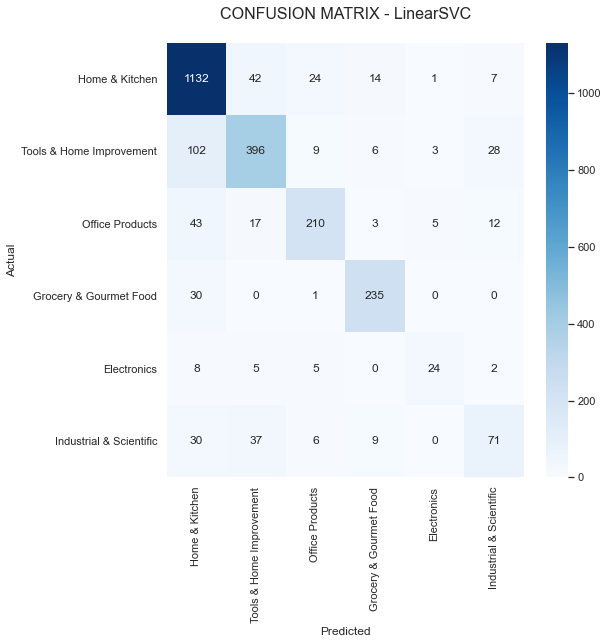

In [16]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.category.values, 
            yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

## Sentence Embedding based Similarity

In [17]:

from sentence_transformers import SentenceTransformer, models
from torch import nn

from sklearn.metrics.pairwise import cosine_similarity

In [18]:
docs_per_class = train_df.groupby(['category'], as_index=False).agg({'title':list})
docs_per_class.set_index("category", inplace = True)
# docs_per_class
none_title_list=docs_per_class.loc['None']['title']
# none_title_list

In [19]:
# cv=CountVectorizer()
# cat_counts=cv.fit_transform(none_title_list)
# # print(cat_counts)
# tfvectorizer_title=TfidfTransformer().fit(X=cat_counts)
# X=tfvectorizer_title.transform(cat_counts)

# # affinity_clustering=AffinityPropagation().fit(X)
# # affinity_clustered=list(affinity_clustering.labels_)

# # # affinity_clustered
# # aff_mean_indices=AffinityPropagation().fit_predict(X)
# # aff_mean_indices


In [20]:
"""Bert Model for Sentence Embedding for each Title  """

word_embedding_model = models.Transformer('distilbert-base-uncased', max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension()).to('cuda:0')
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=64,
                           activation_function=nn.Tanh()).to('cuda:0')
sent_model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model]).to('cuda:0')




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
labeled_df=train_df[train_df['category']!='None']
display(labeled_df)

unlabeled_df=train_df[train_df['category']=='None']
display(unlabeled_df)

category_id_df = label_df[['category', 'category_label']].drop_duplicates()
category_id_df


,title,category
1,Home Essentials Blue Floral Glass Vintage Styl...,Home & Kitchen
2,Cooper Wiring Quiet Toggle Switch Single Pole ...,Tools & Home Improvement
3,Baseboarders&reg; Wall Brackets,Tools & Home Improvement
4,The Great Wave Off Kanagawa Custom Rectangle M...,Office Products
5,Nemcor Pittsburgh Penguins NHL #1 Ultimate Fan...,Home & Kitchen
...,...,...
20175,Curtain Chic Supple Microfiber Cumberbund Vala...,Home & Kitchen
20176,Jack &amp; Jason's Pancake &amp; Waffle Mix - ...,Grocery & Gourmet Food
20178,4 Swivel Casters 4&quot; Rubber Double Brake B...,Industrial & Scientific
20185,Patriotic Flip Flop Ornament Assortment of 2,Home & Kitchen


,title,category
0,The Three Amigos,None
6,"Patrician Berkley 5-Piece Comforter Set, King",None
7,SouvNear 814614025003 Silver Color Deer Knob,None
9,Rilakkuma Bowl,None
15,Mikasa Love Story Perfume Bottle,None
...,...,...
20181,"Rosy Rings hfs-rcc Home Fragrance Spray, Red C...",None
20182,South Mission Saddleback Modern Adjustable Lea...,None
20183,D0309-WML Leviton Decora Screwless Snap-On Wal...,None
20184,South Shore Axess Small 2-Door Storage Cabinet...,None


,category,category_label
1,Home & Kitchen,0
2,Tools & Home Improvement,1
4,Office Products,2
13,Grocery & Gourmet Food,3
53,Electronics,4
75,Industrial & Scientific,5


In [22]:
text=train_df['title']
title_sent_vec=sent_model.encode([text])


In [23]:
category_list=category_id_df['category'].tolist()
category_sent_vec=sent_model.encode(category_list)

unlabeled_title_text=unlabeled_df['title'].tolist()
unlabeled_title_vec=sent_model.encode(unlabeled_title_text)


In [24]:
unlabeled_title_text=unlabeled_df['title'].tolist()
unlabeled_title_vec=sent_model.encode([unlabeled_title_text[1]])
print('unlabel_sent_vec',unlabeled_title_vec)
#category_sent_vec.shape
word_similarity=cosine_similarity(category_sent_vec)
# plt.imshow(word_simililarity)
word_doc_similarity = cosine_similarity(category_sent_vec, unlabeled_title_vec)
print('cosine similarity with category with sentence vector\n',word_doc_similarity) 

unlabel_sent_vec [[-0.18694244  0.06099904 -0.12841915 -0.19555865  0.12374379  0.05086873
  -0.26283848  0.09421322 -0.12638934  0.09767914  0.20776574 -0.18596067
  -0.08232059  0.2321781  -0.00959699  0.09286959 -0.11199871 -0.03885348
   0.18299225  0.23329987  0.20161581  0.04903064  0.16213092  0.04190089
  -0.1688946  -0.40806445  0.0243363   0.28632936  0.10271044 -0.08876863
  -0.07418554  0.02140539 -0.17272438  0.34478936  0.22799942 -0.15997626
  -0.23499528  0.19606173 -0.01507708  0.22619152  0.22159006 -0.01374725
  -0.13892737 -0.17143121  0.06279856 -0.05924424  0.07920078  0.00977432
   0.21026167 -0.16196229 -0.12691094  0.0597975  -0.10790148 -0.3118806
  -0.08611862 -0.04694453  0.04051111  0.27318496 -0.24312931 -0.0034496
  -0.03179641  0.00354343 -0.0230208   0.05458108]]
cosine similarity with category with sentence vector
 [[0.6897061 ]
 [0.73667526]
 [0.5113599 ]
 [0.7210243 ]
 [0.3485567 ]
 [0.54139245]]


## Label Propogation and Label spreading 

## Road map:
    cosine similarty across Not None category and sentence embedding that would be X 

    Training Label Propogation to predict label for unlabeled data

In [25]:
X=train_df['title']
y=train_df['category'].factorize()[0]
y

array([0, 1, 2, ..., 1, 0, 2], dtype=int64)

In [26]:
len(unlabeled_df['title'])

10123

In [27]:
from numpy import concatenate

In [28]:
X_test=labeled_df['title'][8000:]
X_test_cat=labeled_df['title'][8000:]

y_test=list(labeled_df['category'][8000:].factorize()[0])
# y_test_cat=l.unique()



X_train_label=labeled_df['title'][:8000]
X_test_unlabel=unlabeled_df['title'][:1000]

y_train_label=label_df['category_label'][:8000]
# create "no label" for unlabeled data
# nolabel = np.full((1000,4),-1)


In [29]:
print(X_test[:2],'\n',y,category_list,'\n')
print(X_train_label[:2])

16080                      Aastra M8004 Telephone Charcoal
16081    Fatboy Tsjonge Bean Bag Ottoman, Chiase Lounge...
Name: title, dtype: object 
 [0 1 2 ... 1 0 2] ['Home & Kitchen', 'Tools & Home Improvement', 'Office Products', 'Grocery & Gourmet Food', 'Electronics', 'Industrial & Scientific'] 

1    Home Essentials Blue Floral Glass Vintage Styl...
2    Cooper Wiring Quiet Toggle Switch Single Pole ...
Name: title, dtype: object


In [30]:
def sent_cosine_similarity(text,category_list):
    sent_vec=sent_model.encode([text])
    category_vec=sent_model.encode(category_list)
    word_doc_similarity = cosine_similarity(sent_vec, category_vec)
    return word_doc_similarity

In [31]:
X_train_label_sim=[sent_cosine_similarity(i,category_list) for i in X_train_label]
X_test_unlabel_sim=[sent_cosine_similarity(i,category_list) for i in X_test_unlabel]


In [32]:
print(np.array(X_train_label_sim[:5]))
print(np.array(X_test_unlabel_sim[:3]))
print(np.shape(X_train_label_sim))



[[[0.7066552  0.7757016  0.58968043 0.83762354 0.41809556 0.61678624]]

 [[0.61890817 0.66794467 0.51864153 0.62351334 0.44158337 0.5649061 ]]

 [[0.72588485 0.84165543 0.7184363  0.7714893  0.54751873 0.78190124]]

 [[0.65921354 0.68646526 0.53658754 0.7281722  0.35838726 0.58556986]]

 [[0.6848918  0.752672   0.60543865 0.7908283  0.4245471  0.6712499 ]]]
[[[0.6629971  0.71889114 0.71030927 0.7270038  0.62069637 0.74167603]]

 [[0.6897061  0.73667526 0.5113599  0.7210243  0.3485567  0.54139245]]

 [[0.7048045  0.70229805 0.5719746  0.7580607  0.3959477  0.6270167 ]]]
(8000, 1, 6)


In [33]:
X_train_label_npy=np.array([np.hstack(i) for i in X_train_label_sim])
print(X_train_label_npy[1])

X_test_unlabel_sim_npy=np.array([np.hstack(i) for i in X_test_unlabel_sim])
print(X_test_unlabel_sim_npy[1])


[0.61890817 0.66794467 0.51864153 0.62351334 0.44158337 0.5649061 ]
[0.6897061  0.73667526 0.5113599  0.7210243  0.3485567  0.54139245]


In [34]:
print(X_test_unlabel_sim_npy[1])


[0.6897061  0.73667526 0.5113599  0.7210243  0.3485567  0.54139245]


In [35]:

x_concat=np.concatenate((X_train_label_npy,X_test_unlabel_sim_npy))
print(x_concat)



[[0.7066552  0.7757016  0.58968043 0.83762354 0.41809556 0.61678624]
 [0.61890817 0.66794467 0.51864153 0.62351334 0.44158337 0.5649061 ]
 [0.72588485 0.84165543 0.7184363  0.7714893  0.54751873 0.78190124]
 ...
 [0.6957747  0.7504053  0.6080399  0.7492202  0.48081854 0.7022941 ]
 [0.75549155 0.8020327  0.59962994 0.77132475 0.4258249  0.6637558 ]
 [0.6358941  0.6984172  0.52607584 0.74747634 0.3272091  0.6068331 ]]


In [36]:
nolabel=[-1 for _ in range(1000)]

y_concat=np.concatenate((y_train_label,nolabel))


In [37]:
...
# define model
model = LabelPropagation()

# fit model on training dataset
model.fit(x_concat, y_concat)

LabelPropagation()

In [40]:
# X_test
X_test_sim=[sent_cosine_similarity(i,category_list) for i in X_test]

In [41]:
X_test_sim_npy=np.array([np.hstack(i) for i in X_test_sim])
print(X_test_sim_npy[:10])
# ...
# make predictions on hold out test set
yhat = model.predict(X_test_sim_npy)


[[0.68196374 0.69000983 0.67093223 0.7064012  0.5864856  0.5743021 ]
 [0.69386756 0.6755555  0.56361353 0.7081722  0.38425425 0.6276211 ]
 [0.6257992  0.6519385  0.5214322  0.6796349  0.38478523 0.59189844]
 [0.6168037  0.76012594 0.5942227  0.7066109  0.47885153 0.67433584]
 [0.704332   0.7568884  0.6088157  0.7730858  0.52474195 0.68622875]
 [0.6415737  0.7228287  0.5714025  0.70874405 0.4539551  0.65923995]
 [0.5857946  0.71784276 0.5088227  0.6674139  0.34756637 0.58311945]
 [0.6805272  0.729489   0.610538   0.7980414  0.47510076 0.6646056 ]
 [0.61584646 0.6912305  0.5063179  0.7169594  0.33831614 0.5837647 ]
 [0.709771   0.75074196 0.5830436  0.7583393  0.45062977 0.63353384]]


In [42]:
from sklearn.metrics import accuracy_score
# calculate score for test set
score = accuracy_score(y_test, yhat)

# summarize score
print('Accuracy: %.3f' % (score*100))

Accuracy: 11.719


#################
## Let give a try to Deep learning Models and Kfold 

# Decision Tree

### The main idea of a decision tree is to identify the features which contain the most information regarding the target feature and then split the dataset along the values of these features such that the target feature values at the resulting nodes are as pure as possible. A feature that best separates the uncertainty from information about the target feature is said to be the most informative feature. The search process for a most informative feature goes on until we end up with pure leaf nodes.

### Entropy: It is used to measure the impurity or randomness of a dataset.

### 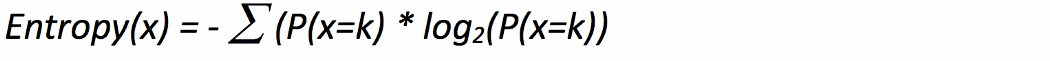


### Information Gain: To find the best feature which serves as a root node in terms of information gain, we first use each descriptive feature and split the dataset along the values of these descriptive features and then calculate the entropy of the dataset. This gives us the remaining entropy once we have split the dataset along the feature values. Then, we subtract this value from the originally calculated entropy of the dataset to see how much this feature splitting reduces the original entropy which gives the information gain of a feature and is calculated as:

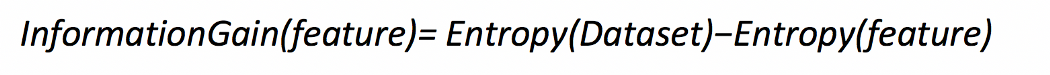


### The feature with the largest information gain should be used as the root node to start building the decision tree.

## Gini Impurity 
### Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset.

### A feature with a lower Gini index is chosen for a split.

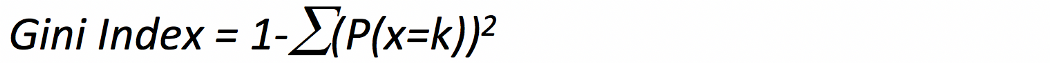

#### Ref: https://www.youtube.com/watch?v=LDRbO9a6XPU
#### https://blog.clairvoyantsoft.com/entropy-information-gain-and-gini-index-the-crux-of-a-decision-tree-99d0cdc699f4
#### https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb
#### https://github.com/random-forests/tutorials/blob/master/decision_tree.py

# Lets go through soe basic concepts of Deep learning


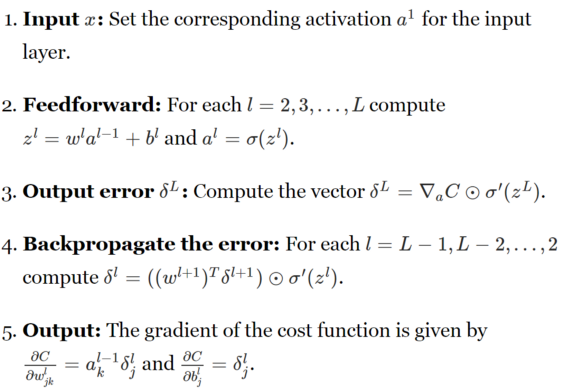

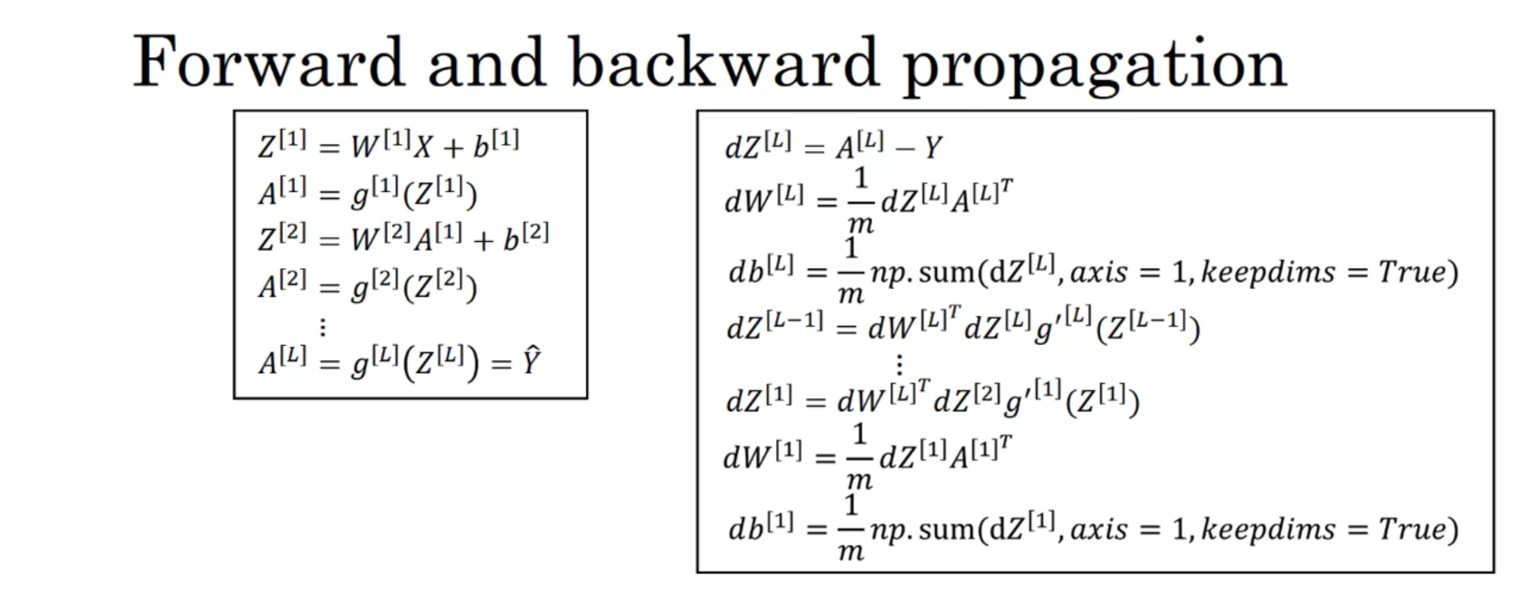

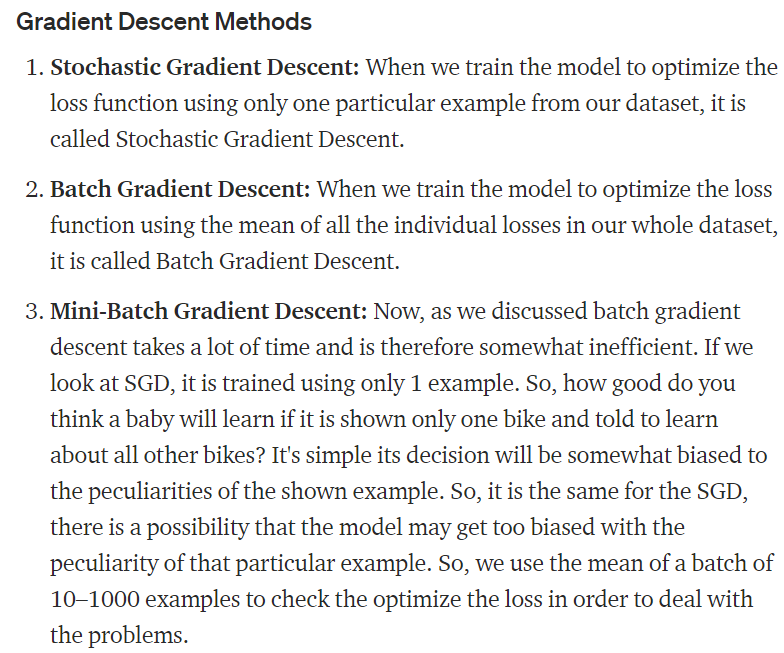

## Backpropogation
### Backpropagation aims to minimize the cost function by adjusting network’s weights and biases.
### The derivative of a function C measures the sensitivity to change of the function value (output value) with respect to a change in its argument x (input value).

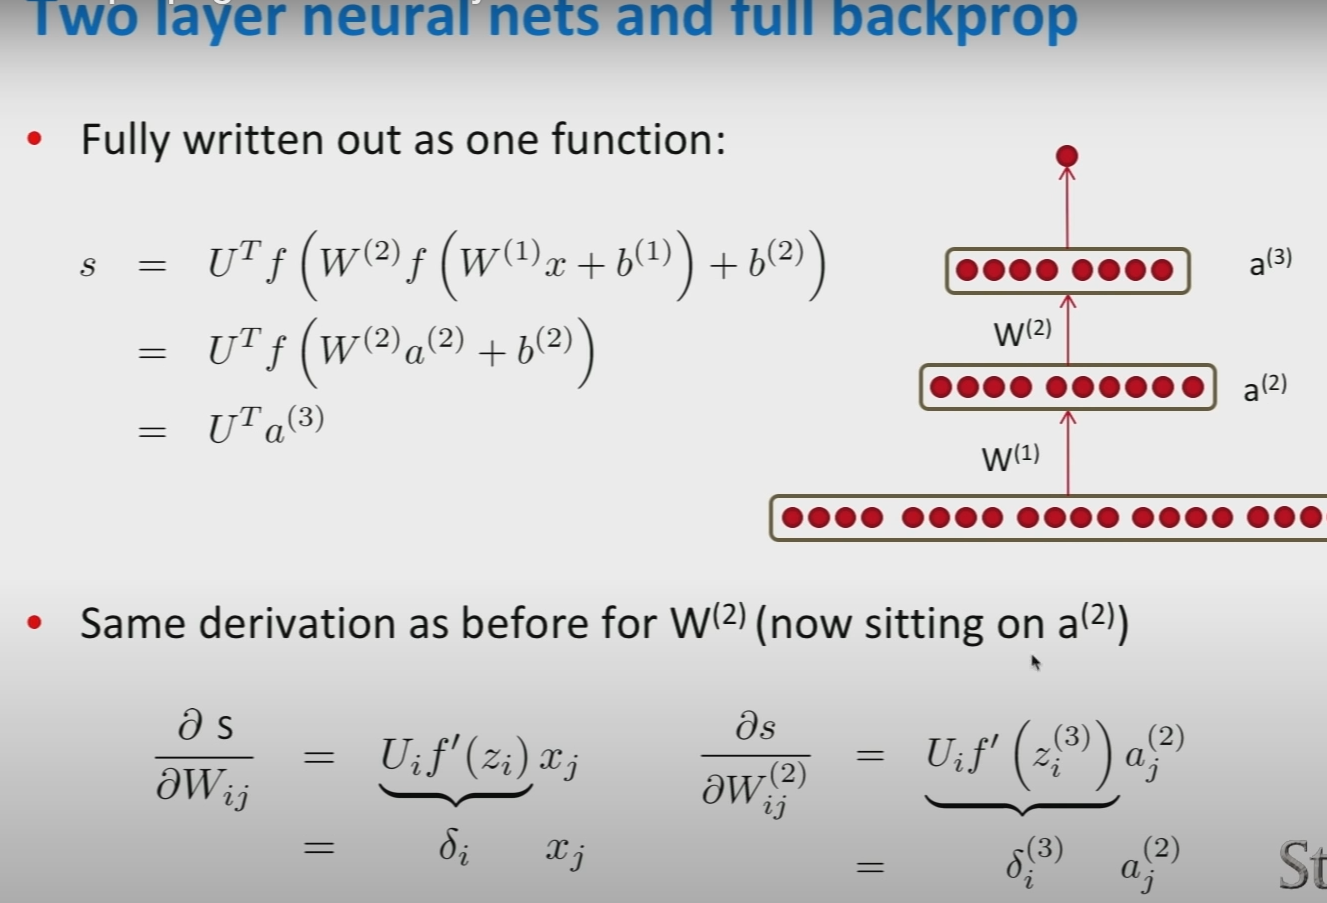

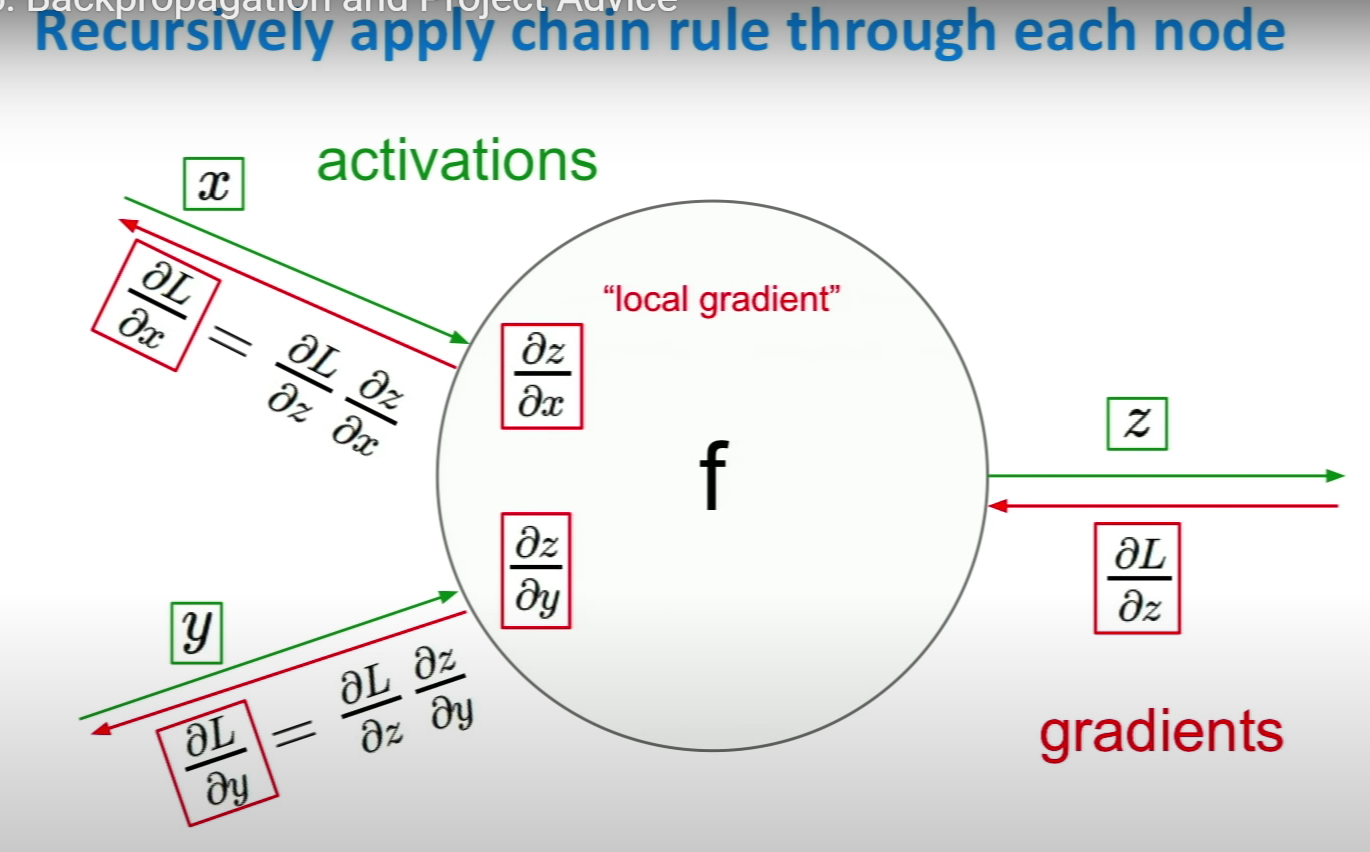

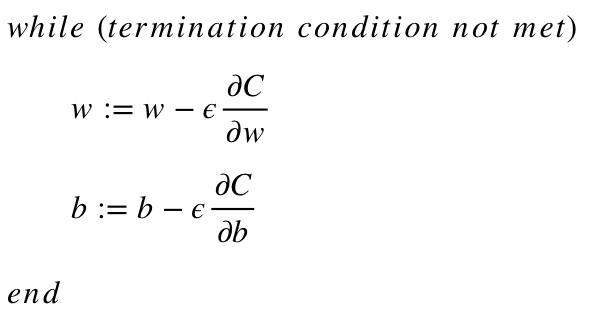

## REF

https://www.youtube.com/watch?v=isPiE-DBagM&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6 \
https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd

## RNN and LSTM
https://d2l.ai/chapter_recurrent-neural-networks/rnn.html \
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21 \


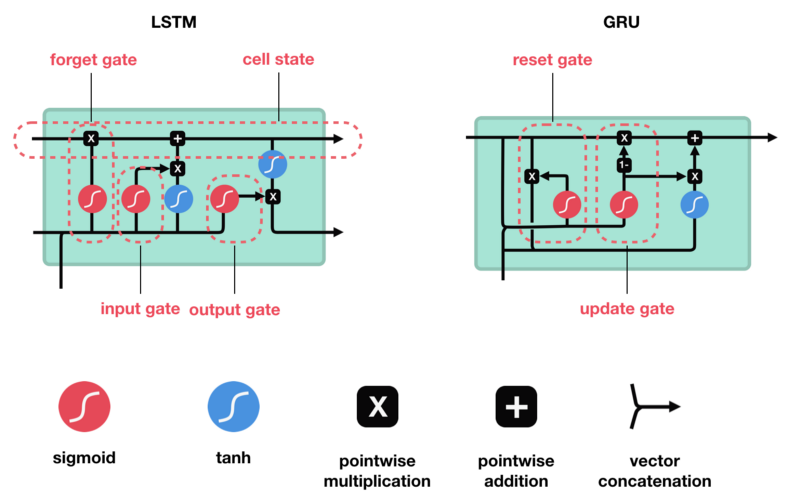

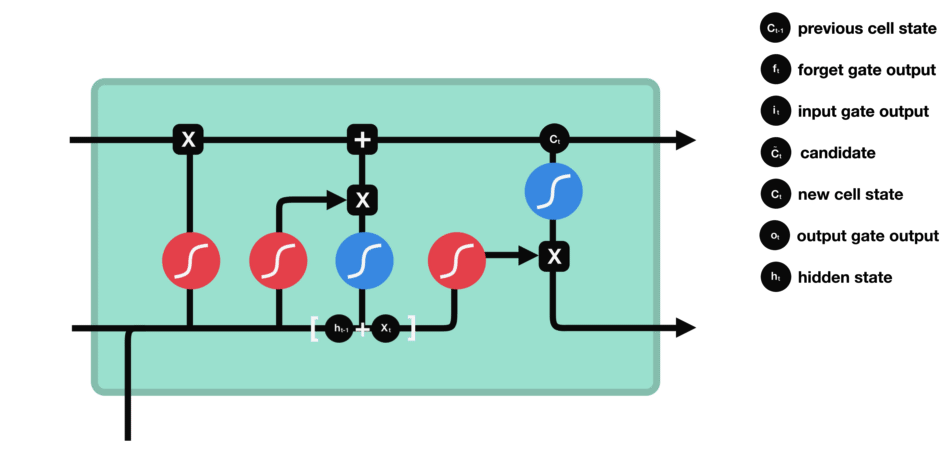